In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
tf.__version__
from PIL import Image
import glob

from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import BatchNormalization


## Image data loader and Exploration

In [2]:

image_list = []
for filepath in glob.glob('trafficsigns_dataset/*/*/*.png', recursive=True):
    filename = filepath.split("\\")[-1]
    signShape = filepath.split("\\")[1]
    signType = filepath.split("\\")[2]
    image_list.append((filepath, signShape, signType))
    
data = pd.DataFrame(data=image_list, columns=['image_path','signShape','signType'])

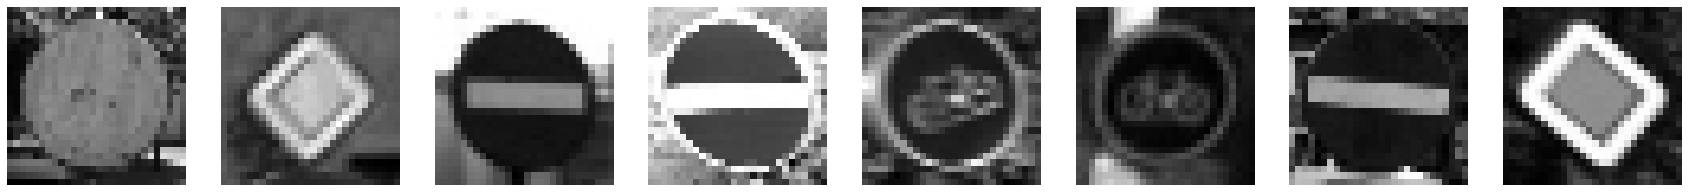

In [3]:
r_inx = np.random.choice(1000, 8)
rand_data = data.loc[r_inx,'image_path']

plt.figure(figsize=(30,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,8,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

In [4]:
data_type=data[['image_path','signType']]


In [5]:
data_type.shape

(3699, 2)

In [6]:
data_type.head()

,image_path,signType
0,trafficsigns_dataset\diamond\rightofway\00032_...,rightofway
1,trafficsigns_dataset\diamond\rightofway\00032_...,rightofway
2,trafficsigns_dataset\diamond\rightofway\00032_...,rightofway
3,trafficsigns_dataset\diamond\rightofway\00037_...,rightofway
4,trafficsigns_dataset\diamond\rightofway\00037_...,rightofway


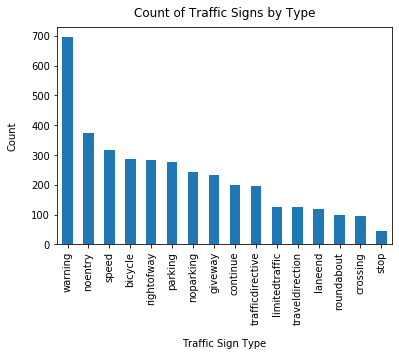

In [7]:
data_type.signType.value_counts().plot(kind='bar')
plt.xlabel("Traffic Sign Type", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Count of Traffic Signs by Type", y=1.02);

### Looking at the above graph we can see that this is an imbalance class problem. To tackle this we could use weighted model or do some data augmentation. 

In [8]:
data_type.signType.value_counts()

warning             695
noentry             375
speed               316
bicycle             285
rightofway          282
parking             276
noparking           242
giveway             231
continue            199
trafficdirective    195
limitedtraffic      125
traveldirection     124
laneend             118
roundabout           98
crossing             95
stop                 43
Name: signType, dtype: int64

In [9]:
# Convert string labels to numeric
#d = {'diamond':0,'hex':1,'round':2,'square':3,'triangle':4}
#data_shape['labels_num'] = data_shape['signShape'].map(d, na_action='ignore')

## Data for Independent Evaluation

##### Independent Evaluation dataset pre processing

In [55]:
fname=data_ind['image_path']

import cv2
import os

for file in fname:
    image = cv2.imread(file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (28,28) , interpolation = cv2.INTER_AREA)
    cv2.imwrite(os.path.join(file), resized)

In [54]:
image_list = []
for filepath in glob.glob('traffic_sign_data_independent_eval_new/*/*/*.png', recursive=True):
    filename = filepath.split("\\")[-1]
    signShape = filepath.split("\\")[1]
    signType = filepath.split("\\")[2]
    image_name=filepath.split("\\")[3]
    image_list.append((filepath, signShape, signType,image_name))
    
data_ind = pd.DataFrame(data=image_list, columns=['image_path','signShape','signType','image_name'])

data_ind_test=data_ind[['image_path','signType']]

ind_tst_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

ind_test_generator = ind_tst_datagen.flow_from_dataframe(
    dataframe=data_ind_test,
    directory='./',
    x_col="image_path",
    y_col="signType",
    target_size=(28, 28),
    batch_size=1,
    shuffle=False,
    class_mode='categorical')


Found 175 validated image filenames belonging to 16 classes.


In [12]:
def ind_eval_m(history):
    ind_test_generator.reset()
    Y_pred = model.predict_generator(ind_test_generator)
    y_pred= np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(ind_test_generator.classes, y_pred))
    print('Classification Report')
    target_names = ['bicycle', 'continue', 'crossing','giveway','laneend','limitedtraffic','noentry','noparking','parking','rightofway','roundabout','speed','stop','trafficdirective','traveldirection','warning']
    print(classification_report(ind_test_generator.classes, y_pred, target_names=target_names))

# Predict the Type of the traffic sign

#### Test Train validation Split

In [13]:
data_type.head()

,image_path,signType
0,trafficsigns_dataset\diamond\rightofway\00032_...,rightofway
1,trafficsigns_dataset\diamond\rightofway\00032_...,rightofway
2,trafficsigns_dataset\diamond\rightofway\00032_...,rightofway
3,trafficsigns_dataset\diamond\rightofway\00037_...,rightofway
4,trafficsigns_dataset\diamond\rightofway\00037_...,rightofway


In [14]:
X=data_type[['image_path']]
Y=data_type[['signType']]

In [15]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY= train_test_split(X,Y,test_size=0.1,random_state=100)


In [16]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(3329, 1)
(370, 1)
(3329, 1)
(370, 1)


In [17]:
testY.signType.value_counts()

warning             70
noentry             41
parking             33
noparking           30
bicycle             28
speed               26
giveway             24
rightofway          21
trafficdirective    21
continue            18
crossing            12
laneend             12
limitedtraffic      11
traveldirection      9
stop                 9
roundabout           5
Name: signType, dtype: int64

In [18]:
trainY.signType.value_counts()

warning             625
noentry             334
speed               290
rightofway          261
bicycle             257
parking             243
noparking           212
giveway             207
continue            181
trafficdirective    174
traveldirection     115
limitedtraffic      114
laneend             106
roundabout           93
crossing             83
stop                 34
Name: signType, dtype: int64

In [19]:
trainX1, valX, trainY1, valY= train_test_split(trainX,trainY,test_size=0.2,random_state=231)

In [20]:
print(trainX1.shape)
print(valX.shape)
print(trainY1.shape)
print(valY.shape)


(2663, 1)
(666, 1)
(2663, 1)
(666, 1)


In [21]:
trainY1['signType'].value_counts()

warning             511
noentry             253
speed               237
rightofway          210
bicycle             195
parking             192
noparking           177
giveway             163
continue            146
trafficdirective    140
traveldirection      95
limitedtraffic       90
laneend              86
roundabout           71
crossing             67
stop                 30
Name: signType, dtype: int64

In [22]:
train_df=pd.concat([trainX1,trainY1],axis=1)
val_df=pd.concat([valX,valY],axis=1)
test_df=pd.concat([testX,testY],axis=1)

In [23]:
N_train_images = train_df.shape[0]
N_val_images = val_df.shape[0]
N_test_images=test_df.shape[0]

In [24]:
print("Training data shape:   ",train_df.shape)
print("Validation data shape: ",val_df.shape)
print("Testing data shape:    ",test_df.shape)

Training data shape:    (2663, 2)
Validation data shape:  (666, 2)
Testing data shape:     (370, 2)


##### Calculating the weights for the model

In [25]:
from sklearn.utils import class_weight
ytrain = np.array(train_df['signType'])
class_weights = class_weight.compute_class_weight('balanced', np.unique(ytrain), ytrain)

## Creating Test/Train/Validation Data Generators

In [26]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
tst_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

##### Train Data Generator

In [27]:
batch_size = 32
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='./',
    x_col="image_path",
    y_col="signType",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical')

Found 2663 validated image filenames belonging to 16 classes.


##### Validation Data Generator

In [28]:
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='./',
    x_col="image_path",
    y_col="signType",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical')


Found 666 validated image filenames belonging to 16 classes.


##### Test Data Generator

In [29]:

test_generator = tst_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='./',
    x_col="image_path",
    y_col="signType",
    target_size=(28, 28),
    batch_size=1,
    shuffle=False,
    class_mode='categorical')

Found 370 validated image filenames belonging to 16 classes.


### Defining Neural Net Architecture with 1 hidden layer using ReLU/sigmoid/softmax activations

###### Model 1

In [58]:
input_ = Input(shape=(28, 28, 3))
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)
#Hidden layer
h = Dense(64)(x)
h = Activation('sigmoid')(h)
# Output layer
out_ = Dense(16)(h)
out_ = Activation('softmax')(out_)

model_1 = Model(inputs=input_, outputs=out_) # Setup the model

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_1.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

model_1.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda_16 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                50240     
_________________________________________________________________
activation_57 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 16)                1040      
_________________________________________________________________
activation_58 (Activation)   (None, 16)                0   

###### Model 2

In [59]:
input_ = Input(shape=(28, 28, 3))
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)
#Hidden layer
h = Dense(64)(x)
h = Activation('relu')(h)
# Output layer
out_ = Dense(16)(h)
out_ = Activation('softmax')(out_)

model_2 = Model(inputs=input_, outputs=out_) # Setup the model

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_2.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

model_2.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda_17 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)                50240     
_________________________________________________________________
activation_59 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 16)                1040      
_________________________________________________________________
activation_60 (Activation)   (None, 16)                0   

#### Model 3 Including Regularization

In [60]:
# Input layer
input_ = Input(shape=(28, 28, 3)) # This is the input shape
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

# Hidden layer
h = Dense(64,kernel_regularizer=regularizers.l2(0.01))(x) # reg for weight matrix 1
h = Activation('relu', name='hidden_layer')(h)

# Output layer
out_ = Dense(16,kernel_regularizer=regularizers.l2(0.01))(h) # reg for weight matrix 2
out_ = Activation('softmax')(out_)

# Define model
model_reg = Model(inputs=input_, outputs=out_)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_reg.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])


model_reg.summary()

# Creating a model for feature vizualization (will be explained later)
hidden_features = Model(inputs=input_, outputs=h)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda_18 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                50240     
_________________________________________________________________
hidden_layer (Activation)    (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 16)                1040      
_________________________________________________________________
activation_61 (Activation)   (None, 16)                0   

###### Model 4  Trying drop outs, Model 5 using adam optimizer

In [61]:

# Input layer
input_ = Input(shape=(28, 28, 3)) # This is the input shape
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

# Hidden layer
h = Dense(64)(x) 
h = Activation('relu')(h)
h= Dropout(rate=0.5)(h)

# Output layer
out_ = Dense(16)(h) 
out_ = Activation('softmax')(out_)

# Define model
model_drop = Model(inputs=input_, outputs=out_)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_drop.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])



model_drop.summary()




# Input layer
input_ = Input(shape=(28, 28, 3)) # This is the input shape
input_slice = (lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784


# Hidden layer
h = Dense(64)(x) 
h = Activation('relu')(h)
h= Dropout(rate=0.5)(h)

# Output layer
out_ = Dense(16)(h) 
out_ = Activation('softmax')(out_)

# Define model using adam optimizer
model_drop_a = Model(inputs=input_, outputs=out_)


model_drop_a.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])


model_drop_a.summary()



Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda_19 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                50240     
_________________________________________________________________
activation_62 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 16)                104

##### Creating model functions

In [62]:
def calculate_losses(model_, data_generator_, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0
    for x,y in data_generator_:
        loss,acc = model_.evaluate(x, y, verbose=0)
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because# the generator loops indefinitely
            break
    return np.mean(loss_hold), np.mean(acc_hold)

In [63]:
def train_model(model_, num_epoch=100, verbose=1):
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

In [36]:



def train_model_weighted(model_, num_epoch=100, verbose=1):
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator:
            loss, acc = model_.train_on_batch(x, y, 
                                              class_weight=class_weights) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

In [37]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])
    plt.show()

In [38]:
#Confution Matrix and Classification Report

def eval_m(mod):
    test_generator.reset()
    Y_pred = mod.predict_generator(test_generator)
    y_pred= np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(test_generator.classes, y_pred))
    print('Classification Report')
    target_names = ['bicycle', 'continue', 'crossing','giveway','laneend','limitedtraffic','noentry','noparking','parking','rightofway','roundabout','speed','stop','trafficdirective','traveldirection','warning']
    print(classification_report(test_generator.classes, y_pred, target_names=target_names))

##### Training and evaluating model 1-5 

*******************************CNN model Start************************************




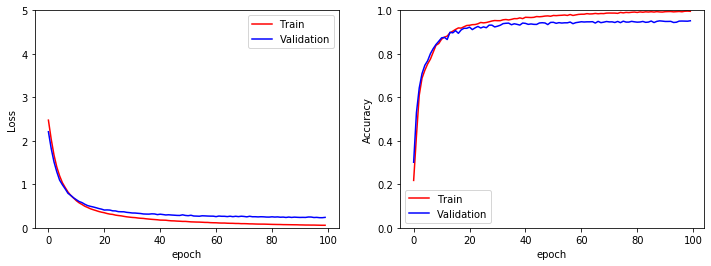

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0 38  1  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  3  0  0  0  0  0  1  0 17  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0 69]]
Classification Report
                  precision    recall  f1-score   support

     

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


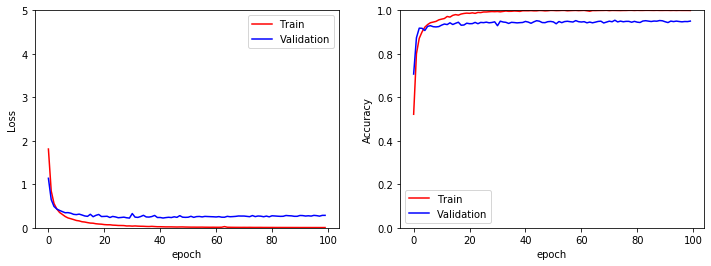

Confusion Matrix
[[27  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 23  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0 38  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0 19  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 26  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0 18  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0 69]]
Classification Report
                  precision    recall  f1-score   support

         bicycle       0.96      0.96      0.96        28
        continue       1.00

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         bicycle       0.43      0.43      0.43         7
        continue       0.38      1.00      0.55         3
        crossing       0.00      0.00      0.00         4
         giveway       0.82      1.00      0.90        14
         laneend       1.00      0.60      0.75         5
  limitedtraffic       0.40      0.40      0.40        10
         noentry       0.00      0.00      0.00        11
       noparking       0.11      0.43      0.17         7
         parking       0.21      0.80      0.33         5
      rightofway       0.31      0.42      0.36        24
      roundabout       0.00      0.00      0.00         9
           speed       0.00      0.00      0.00        15
            stop       1.00      0.10      0.17        21
trafficdirective       0.00      0.00      0.00         6
 traveldirection       0.43      0.18      0.25        17
         warning       0.91      0.67      0.77        15

        accu

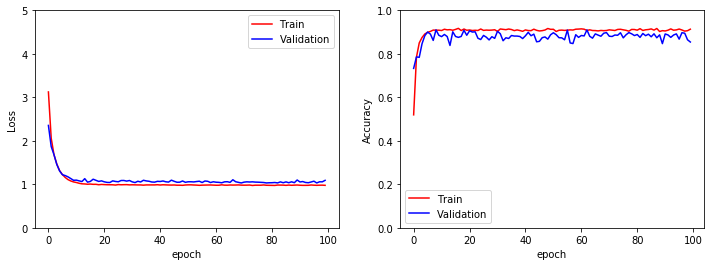

Confusion Matrix
[[24  0  0  0  0  0  2  2  0  0  0  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  7  0  0  0  0  0  4  0  0  0  0]
 [ 1  0  0  0  0  0 38  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  0 31  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  2  0  0  0 17  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0 25  0  0  0  0]
 [ 3  0  0  0  0  0  3  1  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 14  0  6  1  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  4  1  0  0  0  0  1  0  0  0 64]]
Classification Report
                  precision    recall  f1-score   support

         bicycle       0.83      0.86      0.84        28
        continue       1.00

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



*******************************CNN model_2 END************************************
*******************************CNN model_4 Start************************************




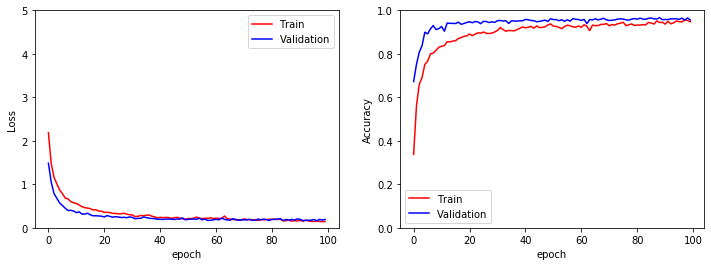

Confusion Matrix
[[28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0 39  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0 24  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  3  0  0  0  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0 69]]
Classification Report
                  precision    recall  f1-score   support

         bicycle       0.97      1.00      0.98        28
        continue       1.00

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


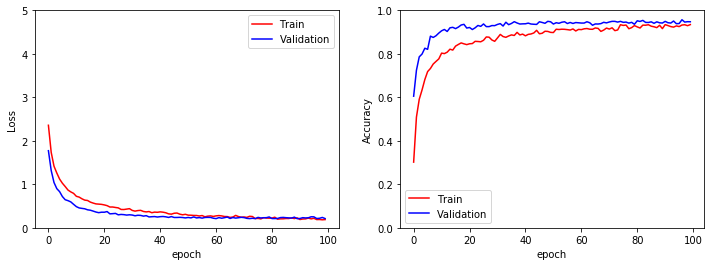

Confusion Matrix
[[28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 39  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  3  0  0  0  0  0  1  0 17  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  1  0  0 68]]
Classification Report
                  precision    recall  f1-score   support

         bicycle       1.00      1.00      1.00        28
        continue       1.00

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
models_list=[model_1,model_2,model_reg,model_drop,model_drop_a]
for model in models_list:
    print("*******************************CNN" , model.name, "Start************************************")
    print("\n")
    res = train_model(model, num_epoch=100, verbose=0)
    plot_results(res)
    eval_m(model)
    print("\n")
    print("**********Independ evealuation result",model.name)
    ind_eval_m(model)
    print("*******************************CNN" , model.name, "END************************************")


The above model seems to overfit since the train accuracy and validation accuracy grew apart as we increased the epochs. The model is overlearning the train data and performing not so good on the validation data. In the following part I have included some regularization to reduce overfitting

##### Training and evaluating model 5-10 with weighted classes

*******************************CNN model_6 Start************************************




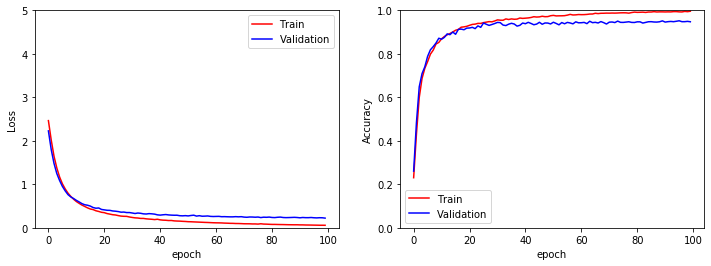

Confusion Matrix
[[28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  1  0  0 38  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 25  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  1  0 17  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  1  1  0  0  0  0  0  0  0  0  0 68]]
Classification Report
                  precision    recall  f1-score   support

         bicycle       0.97      1.00      0.98        28
        continue       1.00

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


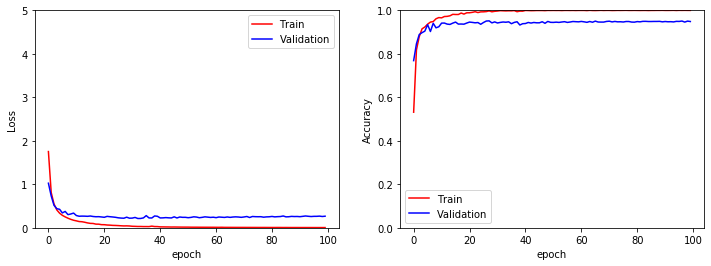

Confusion Matrix
[[28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0 38  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  1 18  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0 69]]
Classification Report
                  precision    recall  f1-score   support

         bicycle       0.97      1.00      0.98        28
        continue       1.00

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


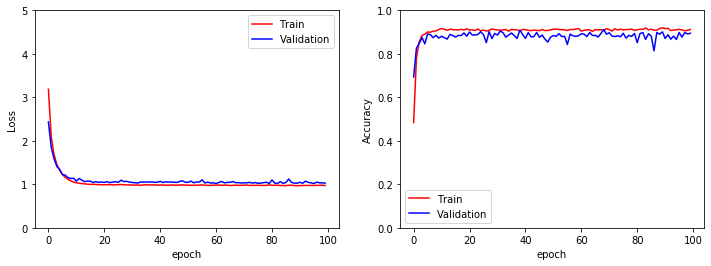

Confusion Matrix
[[27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0 22  0  1  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  1  0]
 [ 1  0  0  0  0  0 38  1  0  0  0  0  0  0  1  0]
 [ 1  0  0  0  0  0  0 29  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  0 31  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  1  0  0  0 19  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0 24  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  2  0 16  1  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0 69]]
Classification Report
                  precision    recall  f1-score   support

         bicycle       0.77      0.96      0.86        28
        continue       1.00

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


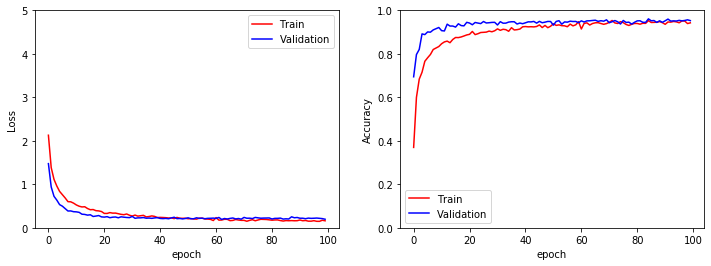

Confusion Matrix
[[27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  1 39  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0 24  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  3  0  0  0  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0 69]]
Classification Report
                  precision    recall  f1-score   support

         bicycle       0.96      0.96      0.96        28
        continue       1.00

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


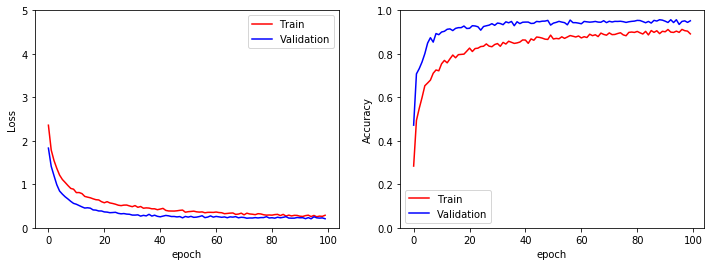

Confusion Matrix
[[28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  1 39  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0 29  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  0 24  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  7  0  1  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0 19  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  1  0  0  0  1  0  0  0  0  0 68]]
Classification Report
                  precision    recall  f1-score   support

         bicycle       0.90      1.00      0.95        28
        continue       1.00

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
models_list=[model_1,model_2,model_reg,model_drop,model_drop_a]
for model in models_list:
    print("*******************************CNN" , model.name, "Start************************************")
    print("\n")
    res = train_model_weighted(model, num_epoch=100, verbose=0)
    plot_results(res)
    eval_m(model)
    print("\n")
    print("**********Independ evealuation result",model.name)
    ind_eval_m(model)
    print("\n")
    print("*******************************CNN" , model.name, "END************************************")


### New Sequential approach - Adding 2 hiden layers with maxPooling and reLU/Softmax activation with dropouts using a weighted model with sgd optimizer

In [40]:
def newplot(history):
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [41]:
def ind_eval(history):
    ind_test_generator.reset()
    Y_pred = history.model.predict_generator(ind_test_generator)
    y_pred= np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(ind_test_generator.classes, y_pred))
    print('Classification Report')
    target_names = ['bicycle', 'continue', 'crossing','giveway','laneend','limitedtraffic','noentry','noparking','parking','rightofway','roundabout','speed','stop','trafficdirective','traveldirection','warning']
    print(classification_report(ind_test_generator.classes, y_pred, target_names=target_names))

In [42]:

def create_1(model,opt='sgd'):
    model.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=(28,28,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())

    model.add(Dense(64))
    model.add(Activation('relu'))


    model.add(Dense(16, activation='softmax'))

    
    if opt=='sgd':
        
        model.compile(optimizer=opt,loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    if opt=='adam':
        
        model.compile(optimizer=opt,loss="categorical_crossentropy", metrics=["categorical_accuracy"])



Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Confusion Matrix
[[26  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 11  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 39  1  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 32  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0 24  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  1  0 19  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  1 68]]
Classification Report
                  precision    recall  f1-s

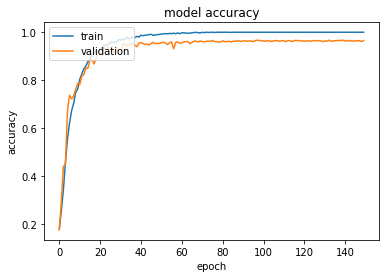

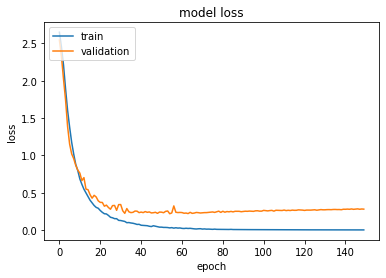

Confusion Matrix
[[ 0  0  0  0  0  0  0  1  0  3  0  0  0  1  1  1]
 [ 0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  1  0  0  0  0  0  0  1  0  0  0  0  0  1]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  3  0  0  1  0  6  0  0]
 [ 1  1  0  0  0  1  0  0  0  3  0  0  0  0  0  1]
 [ 0  1  0  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  3  0 18  0  0  0  0  2  0]
 [ 0  0  0  0  0  3  0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  7  0  7  0  0  0  0]
 [ 0  0  0  0  0  6  1  0  0  1  0  0 12  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0]
 [ 0  2  0  0  0  3  3  2  0  0  0  6  0  1  0  0]
 [ 0  0  0  0  0  0  0  1  0  2  0  0  0  0  2 10]]
Classification Report
                  precision    recall  f1-score   support

         bicycle       0.00      0.00      0.00         7
        continue       0.43

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
Confusion Matrix
[[27  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0 40  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 32  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 26  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0 19  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  1 68]]
Classification Report
                  precision    recall  f1-score   support

 

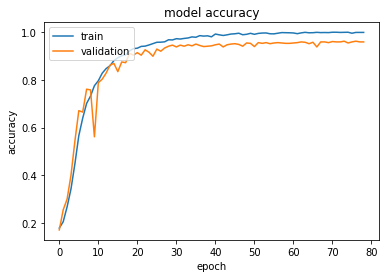

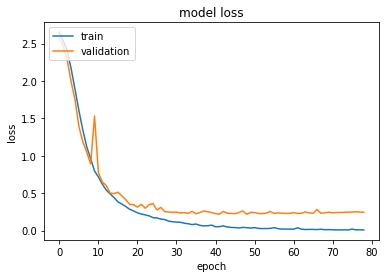

Confusion Matrix
[[ 0  0  0  0  0  0  1  1  0  3  0  0  0  1  1  0]
 [ 0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  2]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  8  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  5  0  0  1  0  4  0  0]
 [ 1  1  0  0  0  0  0  0  0  4  0  0  0  0  0  1]
 [ 0  1  0  0  0  0  0  0  2  0  0  0  0  0  1  1]
 [ 0  0  0  0  0  0  0  3  0 19  0  0  0  0  2  0]
 [ 0  0  0  0  0  2  0  0  0  7  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  4  0  5  0  6  0  0  0  0]
 [ 0  0  0  0  0  8  1  0  0  0  0  0 10  0  1  1]
 [ 0  0  0  0  0  0  0  0  2  0  0  0  0  4  0  0]
 [ 0  5  0  0  0  1  3  2  0  0  0  5  0  0  1  0]
 [ 0  0  0  0  0  0  0  1  0  3  0  0  0  0  0 11]]
Classification Report
                  precision    recall  f1-score   support

         bicycle       0.00      0.00      0.00         7
        continue       0.30

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Confusion Matrix
[[26  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0 39  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 25  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1 20  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 70]]
Classification Report
                  precision    recall  f1-score   support

 

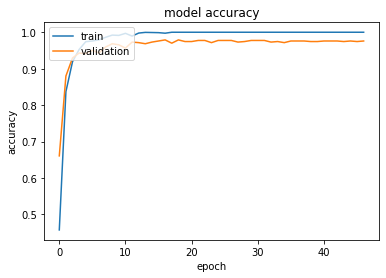

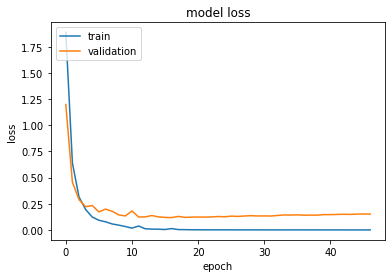

Confusion Matrix
[[ 0  0  0  0  0  0  0  0  0  1  0  1  0  1  2  2]
 [ 0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  9  1  0]
 [ 1  1  0  0  0  0  0  0  0  3  1  0  0  0  0  1]
 [ 0  0  1  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0 20  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  3  0  5  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  2  8  0  5  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0 18  0  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0]
 [ 0  3  0  0  0  0  5  2  0  0  0  6  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15]]
Classification Report
                  precision    recall  f1-score   support

         bicycle       0.00      0.00      0.00         7
        continue       0.33

In [43]:
#This model works better on independent evaluation, F1 score for each category is better, adding class weights doesnot improve th over fitting and independent evaluation is not that good in accuracy and f1 score.

monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=30,verbose=1,restore_best_weights=True)


#create model
model_2layer = Sequential()
create_1(model_2layer,'sgd')
# Train model on dataset
hist=model_2layer.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    epochs=150,verbose=0)
eval_m(model_2layer)
newplot(hist)
ind_eval(hist)

print("\n")
print("********************same as above model with class weights and early stopping*************************")
print("\n")

#create model
model_2layer_v1=Sequential()
create_1(model_2layer_v1,'sgd')


# Train model on dataset
hist_1=model_2layer_v1.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0,
                    class_weight=class_weight)
eval_m(model_2layer_v1)
newplot(hist_1)
ind_eval(hist_1)


#create model
model_2layer_v2=Sequential()
create_1(model_2layer_v2,'adam')


# Train model on dataset
hist_2=model_2layer_v2.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0,
                    class_weight=class_weight)
eval_m(model_2layer_v2)
newplot(hist_2)
ind_eval(hist_2)

##### Model with drop outs

In [44]:
def create_2(model,opt='sgd'):
    
    model.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=(28,28,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(64, (3, 3), padding='same'))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(16, activation='softmax'))
    if opt=='sgd':
        optimizers.SGD(lr=0.01)
        model.compile(optimizer=opt,loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    if opt=='adam':
        optimizers.Adam(lr=0.01)
        model.compile(optimizer=opt,loss="categorical_crossentropy", metrics=["categorical_accuracy"])



  ...
    to  
  ['...']
Confusion Matrix
[[28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 40  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 26  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0 18  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 70]]
Classification Report
                  precision    recall  f1-score   support

         bicycle       1.00      1.00      1.00        28
  

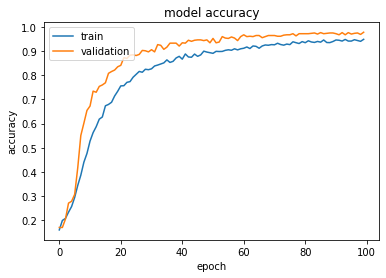

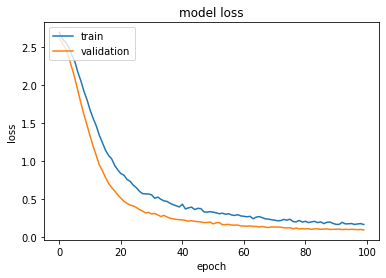

Confusion Matrix
[[ 1  1  1  0  0  0  0  0  0  1  0  0  0  1  0  2]
 [ 0  2  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  3]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  1  0  0  0  0  7  1  1]
 [ 2  0  0  0  0  2  0  1  0  2  0  0  0  0  0  2]
 [ 0  0  1  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  5  0 17  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  1  0  6  1  1  0  6  0  0  0  0]
 [ 2  0  0  0  0  0  1  0  0  0  0  0 18  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  5  0  0]
 [ 0  2  0  0  0  0  7  2  0  0  0  5  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15]]
Classification Report
                  precision    recall  f1-score   support

         bicycle       0.20      0.14      0.17         7
        continue       0.40

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00215: early stopping
Confusion Matrix
[[28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 40  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 26  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  1 18  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 70]]
Classification Report
                  precision    reca

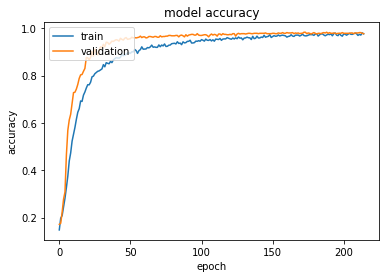

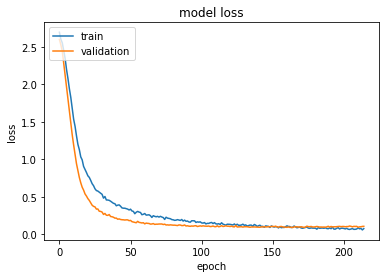

Confusion Matrix
[[ 1  0  0  0  0  0  0  0  0  1  0  0  0  1  2  2]
 [ 0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  3]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  4  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  9  1  0]
 [ 1  0  0  0  0  0  1  1  0  2  0  0  0  1  1  2]
 [ 0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  1  0  3  0 18  0  0  0  0  2  0]
 [ 0  0  0  0  0  3  0  0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  0  8  2  0  0  5  0  0  0  0]
 [ 1  0  0  0  0  2  1  0  0  0  0  0 16  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0]
 [ 0  1  0  0  0  0  6  3  0  0  0  5  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15]]
Classification Report
                  precision    recall  f1-score   support

         bicycle       0.33      0.14      0.20         7
        continue       0.60

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
Confusion Matrix
[[28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 41  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 26  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 70]]
Classification Report
                  precision    reca

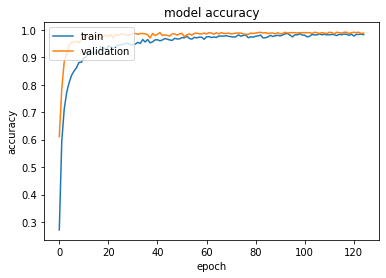

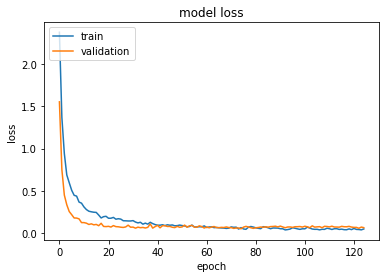

Confusion Matrix
[[ 3  0  0  0  0  0  0  0  0  0  0  0  0  1  1  2]
 [ 0  2  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  8  1  1]
 [ 2  0  0  0  0  1  0  4  0  1  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0 20  0  0  0  0  2  0]
 [ 0  0  0  0  0  1  0  5  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  0 13  0  0  0  0]
 [ 1  0  0  0  0  0  1  0  0  0  0  0 18  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0]
 [ 0  5  0  0  0  0  1  1  2  0  0  0  0  0  5  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15]]
Classification Report
                  precision    recall  f1-score   support

         bicycle       0.50      0.43      0.46         7
        continue       0.29

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:

#create model
model_2layer = Sequential()
create_2(model_2layer,opt='sgd')

# Train model on dataset
histd=model_2layer.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    epochs=100,verbose=0)
eval_m(model_2layer)
newplot(histd)
ind_eval(histd)
#epoch50 accuracy -71
#epoch100 accuracy -81
#epoch150 accuracy -89
#epoch200 accuracy -92
#epoch250 accuracy -92
#No class weights given there fore the minority class 'hex' is being predicted worng in the independent test set.

print("\n")
print("********************same as above model with class weights and early stopping*************************")
print("\n")

#create model
model_2layer_v1=Sequential()
create_2(model_2layer_v1,opt='sgd')

monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=50,verbose=1,restore_best_weights=True)

# Train model on dataset
histd_1=model_2layer_v1.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0,
                    class_weight=class_weight)
eval_m(model_2layer_v1)
newplot(histd_1)
ind_eval(histd_1)



print("\n")
print("********************same as above model with class weights and early stopping optimizer =adam*************************")
print("\n")

#create model
model_2layer_ad=Sequential()
create_2(model_2layer_ad,opt='adam')

monitor=EarlyStopping(monitor='val_loss',min_delta=1e-4,patience=50,verbose=1,restore_best_weights=True)

# Train model on dataset
histd_2=model_2layer_ad.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0,
                    class_weight=class_weight)
eval_m(model_2layer_ad)
newplot(histd_2)
ind_eval(histd_2)



In [46]:


def create_3(model_cnn,opt='sgd'):

    # input
    model_cnn.add(Input(shape=(28, 28, 3)))
    model_cnn.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

    # Conv Layer 1
    model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
    model_cnn.add(Activation('relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv Layer 2 
    model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
    model_cnn.add(Activation('relu'))

    # Conv Layer 3
    model_cnn.add(Conv2D(64, (3, 3)))
    model_cnn.add(Activation('relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

    # MLP
    model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model_cnn.add(Dense(64))
    model_cnn.add(Activation('relu'))
    model_cnn.add(Dropout(0.5))
    model_cnn.add(Dense(16))
    model_cnn.add(Activation('softmax'))

    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model_cnn.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=[categorical_accuracy])

    if opt=='sgd':
        model_cnn.compile(optimizer=opt,loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    if opt=='adam':
        model_cnn.compile(optimizer=opt,loss="categorical_crossentropy", metrics=["categorical_accuracy"])

    model_cnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_10 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_27 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_28 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 9, 9, 64)         

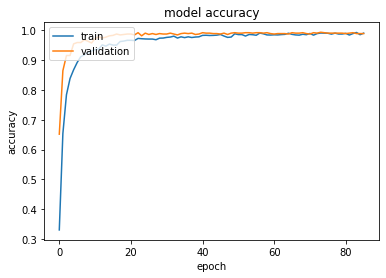

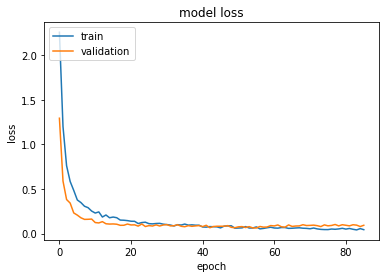

Confusion Matrix
[[ 1  0  0  0  0  0  0  0  0  1  0  0  1  1  1  2]
 [ 0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  6  0  0  0  0  0  3  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  1  0  2  0  0  6  0  0]
 [ 2  1  0  0  0  0  0  0  0  3  0  0  0  0  0  1]
 [ 0  0  1  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0 21  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0 18  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0]
 [ 0 12  0  0  0  0  0  2  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15]]
Classification Report
                  precision    recall  f1-score   support

         bicycle       0.33      0.14      0.20         7
        continue       0.19

In [47]:
#create model
model_cnn_3=Sequential()
create_3(model_cnn_3,opt='adam')

monitor=EarlyStopping(monitor='val_loss',min_delta=1e-4,patience=30,verbose=1,restore_best_weights=True)

# Train model on dataset
histd3_2=model_cnn_3.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0,
                    class_weight=class_weight)
eval_m(model_cnn_3)
newplot(histd3_2)
ind_eval(histd3_2)



Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_15 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_52 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_53 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 9, 9, 64)        

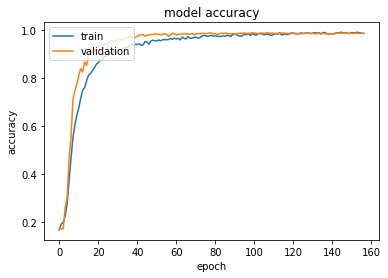

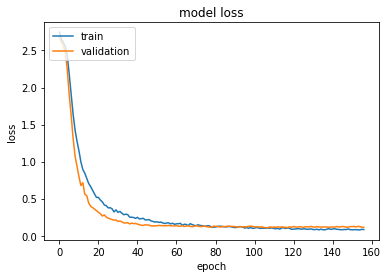

Confusion Matrix
[[ 2  0  0  0  0  0  0  0  0  1  0  0  1  1  1  1]
 [ 0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  8  1  0]
 [ 0  0  0  0  0  0  0  5  0  2  0  0  0  0  0  2]
 [ 0  0  1  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0 21  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  4  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  3  0  0  0 12  0  0  0  0]
 [ 1  0  0  0  0  1  1  0  0  0  0  0 18  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0]
 [ 0 12  0  0  0  0  0  2  0  0  0  1  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15]]
Classification Report
                  precision    recall  f1-score   support

         bicycle       0.67      0.29      0.40         7
        continue       0.20

In [57]:
#create model
model_cnn_3=Sequential()
create_3(model_cnn_3,opt='sgd')

monitor=EarlyStopping(monitor='val_loss',min_delta=1e-4,patience=50,verbose=1,restore_best_weights=True)

# Train model on dataset
histd3_2=model_cnn_3.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0,
                    class_weight=class_weight)
eval_m(model_cnn_3)
newplot(histd3_2)
ind_eval(histd3_2)



### Increasing model complexity by adding more hidden layers

In [51]:


def create_4(model_cnn,opt='sgd'):

    # input
    model_cnn.add(Input(shape=(28, 28, 3)))
    model_cnn.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

    # Conv Layer 1
    model_cnn.add(Conv2D(16, (3, 3),padding='same'))
    model_cnn.add(BatchNormalization)
    model_cnn.add(Activation('relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.2))

    # Conv Layer 2 
    model_cnn.add(Conv2D(32, (3, 3)))
    model_cnn.add(BatchNormalization)
    model_cnn.add(Activation('relu'))

    # Conv Layer 3
    model_cnn.add(Conv2D(32, (3, 3)))
    model_cnn.add(Activation('relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.2))
    
     # Conv Layer 2 
    model_cnn.add(Conv2D(64, (3, 3)))
    model_cnn.add(BatchNormalization)
    model_cnn.add(Activation('relu'))
    
         # Conv Layer 2 
    model_cnn.add(Conv2D(128, (3, 3)))
    model_cnn.add(BatchNormalization)
    model_cnn.add(Activation('relu'))
    

    # MLP
    model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model_cnn.add(Dense(64))
    model_cnn.add(Activation('relu'))
    model_cnn.add(Dropout(0.5))
    model_cnn.add(Dense(16))
    model_cnn.add(Activation('softmax'))

    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model_cnn.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=[categorical_accuracy])

    if opt=='sgd':
        model_cnn.compile(optimizer=opt,loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    if opt=='adam':
        model_cnn.compile(optimizer=opt,loss="categorical_crossentropy", metrics=["categorical_accuracy"])

    model_cnn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_14 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_47 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_48 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 9, 9, 64)        

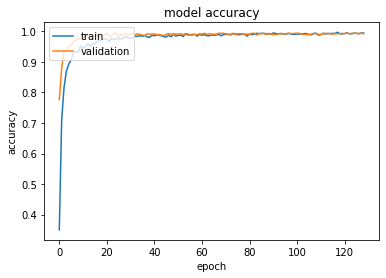

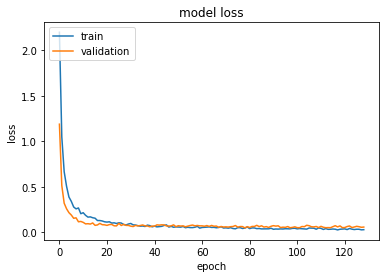

Confusion Matrix
[[ 3  1  0  0  0  0  0  0  0  0  0  0  0  1  0  2]
 [ 0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  2  2  3  0  0  1  1  0]
 [ 0  0  0  0  0  0  0  5  0  2  0  0  0  1  0  1]
 [ 0  0  1  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0 21  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  8  0  0  1  6  0  0  0  0]
 [ 1  0  0  0  0  0  1  0  0  0  0  0 18  0  1  0]
 [ 0  0  0  0  0  0  0  0  2  2  1  0  0  1  0  0]
 [ 0 11  0  0  0  0  0  2  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15]]
Classification Report
                  precision    recall  f1-score   support

         bicycle       0.75      0.43      0.55         7
        continue       0.20

In [56]:
#create model
model_cnn_4=Sequential()
create_3(model_cnn_4,opt='adam')

monitor=EarlyStopping(monitor='val_loss',min_delta=1e-4,patience=50,verbose=1,restore_best_weights=True)

# Train model on dataset
histd3_2_1=model_cnn_4.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0,
                    class_weight=class_weight)
eval_m(model_cnn_4)
newplot(histd3_2_1)
ind_eval(histd3_2_1)



Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_23 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_75 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_76 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 9, 9, 64)        

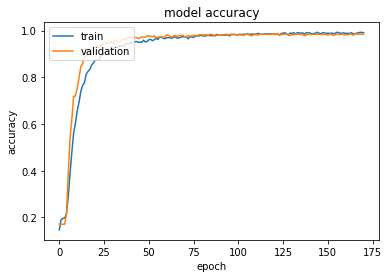

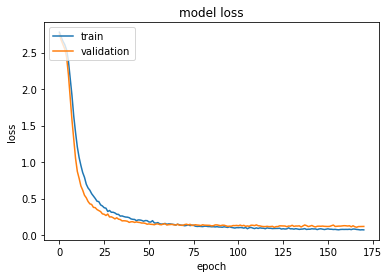

Confusion Matrix
[[ 3  0  0  0  0  0  0  0  0  2  0  0  0  1  1  0]
 [ 0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  1  0  8  1  0]
 [ 0  0  0  0  0  0  0  5  0  2  0  0  0  0  0  2]
 [ 0  1  0  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  1  0 20  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  7  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0 14  0  0  0  0]
 [ 1  0  0  0  0  1  1  0  0  0  0  0 18  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0]
 [ 0  6  0  0  0  0  0  4  0  0  0  0  0  0  6  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15]]
Classification Report
                  precision    recall  f1-score   support

         bicycle       0.75      0.43      0.55         7
        continue       0.30

In [66]:
#create model
model_cnn_5=Sequential()
create_3(model_cnn_5,opt='sgd')

monitor=EarlyStopping(monitor='val_loss',min_delta=1e-4,patience=50,verbose=1,restore_best_weights=True)

# Train model on dataset
histd3_2_2=model_cnn_5.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0,
                    class_weight=class_weight)
eval_m(model_cnn_5)
newplot(histd3_2_2)
ind_eval(histd3_2_2)

